In [1]:
from nfl_data_bowl.data_utils.data_common import load_and_filter_data, filter_passing_plays_only, process_game_scores

In [2]:
import random
random.seed(42)  # Replace 42 with your desired seed value

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import warnings
warnings.filterwarnings('ignore')

# Data Loading

- We are going to load Week 1-9 of data. 
- We will stratify the data by week to prevent any "strategy leakage". 

In [5]:
def count_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    return total_params

import warnings

tracking = load_and_filter_data(weeks=list(range(1,10)), base_path="..")
tracking_passing_only = filter_passing_plays_only(tracking)
tracking_passing_only = process_game_scores(tracking_passing_only)
tracking_passing_only = tracking_passing_only.sort_values(by=["time"])
print(tracking_passing_only.shape)

loaded
merged player play
merged plays
Dropped wasInitialPassRusher due to 100.00% missing values
Dropped timeToPressureAsPassRusher due to 100.00% missing values
Dropped getOffTimeAsPassRusher due to 100.00% missing values
Dropped wasRunningRoute due to 75.81% missing values
Dropped blockedPlayerNFLId1 due to 72.24% missing values
Dropped blockedPlayerNFLId2 due to 97.53% missing values
Dropped blockedPlayerNFLId3 due to 100.00% missing values
Dropped pressureAllowedAsBlocker due to 70.01% missing values
Dropped timeToPressureAllowedAsBlocker due to 97.70% missing values
Dropped pff_primaryDefensiveCoverageMatchupNflId due to 100.00% missing values
Dropped pff_secondaryDefensiveCoverageMatchupNflId due to 100.00% missing values
Filled 0.01% missing values in playClockAtSnap with mean
Dropped passLength due to 45.72% missing values
Dropped targetX due to 47.90% missing values
Dropped targetY due to 47.90% missing values
Dropped dropbackDistance due to 37.04% missing values
Dropped time

In [6]:
tracking_passing_only.loc[
    (tracking_passing_only.routeRan.isna()) & (tracking_passing_only.position.isin(('WR', 'TE', 'RB'))), 
     'routeRan'
] = 'BLOCKING'

In [7]:
train_weeks = list(range(1,7))
val_weeks = list(range(7,9))
test_weeks = list(range(9,10))

# Historical GNN

In [8]:
from nfl_data_bowl.data_utils.data_historical import (
    HistoricalMultiRoutePlayDataset,
    create_game_play_pairs,
    create_batch_data,
    process_game_scores,
    DataMappings,
    create_week_stratified_split
)
from nfl_data_bowl.train import train_route_predictor, MultiRouteLoss
from torch_geometric.loader import DataLoader
import torch
from nfl_data_bowl.utils.evaluate import analyze_distributional_drift, classification_report, plot_rolling_performance, plot_metrics_across_datasets, evaluate_route_predictions_table
import numpy as np
import pandas as pd

In [9]:
unique_routes = sorted([route for route in tracking_passing_only.routeRan.unique() if not pd.isna(route)])
unique_routes

['ANGLE',
 'BLOCKING',
 'CORNER',
 'CROSS',
 'FLAT',
 'GO',
 'HITCH',
 'IN',
 'OUT',
 'POST',
 'SCREEN',
 'SLANT',
 'WHEEL']

### Load Data and Stratify by Week

In [10]:
mappings = DataMappings()
mappings.fit(tracking_passing_only)

In [11]:
import pickle

with open("mapping.pkl", "wb") as f:
    pickle.dump(mappings, f)

In [12]:
# Create a mapping from unique nflIds to 0 to N
unique_ids = tracking_passing_only['nflId'].unique()
id_mapping = {id_: idx for idx, id_ in enumerate(unique_ids)}
# Map the nflId column
tracking_passing_only['nflId'] = tracking_passing_only['nflId'].map(id_mapping)

In [13]:
dataset = HistoricalMultiRoutePlayDataset(
    df=tracking_passing_only,
    game_play_pairs=create_game_play_pairs(tracking_passing_only),
    target_df=tracking_passing_only[['gameId','playId','routeRan']],
    offense_positions=['QB', 'RB', 'WR', 'TE'],
    defense_positions=['CB', 'SS', 'FS', 'LB', 'OLB', 'ILB'],
    eligible_positions=['WR', 'TE', 'RB'],
    n_frames=1,
    device='cpu',
    unique_routes=unique_routes,
    mappings=mappings,  # Pass the mappings object
    n_workers=8,
    teams_per_chunk=4,
    max_history_plays=12,
    augment=False,
    do_not_augment_weeks=[7, 8]
)

Precomputing graphs using team-based parallel processing


Processing team chunks: 100%|████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:16<00:00,  2.06s/it]


In [14]:
train_loader, val_loader, test_loader, indices, week_ranges = create_week_stratified_split(
        dataset, 
        train_weeks=train_weeks,
        val_weeks=val_weeks,
        test_weeks=test_weeks,
        # train_weeks=list(range(1,3)),
        # val_weeks=list(range(3,4)),
        # test_weeks=list(range(3,4)),
        batch_size=128, 
        random_seed=42,
        preserve_time_order=False,
        val_random=False  # Whether to randomly sample validation set from train period
)

Train set size: 6777
Validation set size: 2037
Test set size: 913
Train weeks: [1, 2, 3, 4, 5, 6]
Validation weeks: [7, 8]
Test weeks: [9]


In [15]:
from nfl_data_bowl.models.gnn_historical_enhanced import PlayGNN

In [16]:
freqs = tracking_passing_only[~tracking_passing_only.routeRan.isna()].routeRan.value_counts() / len(tracking_passing_only[~tracking_passing_only.routeRan.isna()])
freqs_sorted = sorted(list(freqs.to_dict().items()))
freqs_sorted
class_weights = torch.FloatTensor([1 - w[1] for w in freqs_sorted])
class_weights**2

tensor([0.9299, 0.7810, 0.9254, 0.8334, 0.7601, 0.7035, 0.7567, 0.8655, 0.8305,
        0.8915, 0.9270, 0.9074, 0.9909])

In [17]:
from nfl_data_bowl.models.analyzable_gnn import AnalyzablePlayGNN

In [18]:
model = PlayGNN(
    num_positions=20,
    hidden_dim=48,
    num_gnn_layers=3,
    num_route_classes=dataset.num_route_classes, # for -1 or NaN
    dropout=0.05,
    max_downs=4,
    max_quarters=5,
    num_teams=32,
)


# Assuming you have a model defined as 'model'
num_weights = count_parameters(model)
print("Number of weights:", num_weights)

# Train model
optimizer = torch.optim.Adam(model.parameters(), lr=0.0015)
train_route_predictor(
    model, 
    train_loader, 
    val_loader, 
    optimizer, 
    num_classes=dataset.num_route_classes, 
    num_epochs=80, device="cpu", 
    allow_overfit=True,
    early_stopping_patience=25,
    debug=False,
    class_weights=(class_weights**2) * 5
)

# Make predictions
model.eval()

Number of weights: 204783
Training model
Epoch 5/80, Train Loss: 2.2499, Holdout Loss: 2.1837, LR: 0.001500
Epoch 10/80, Train Loss: 2.1227, Holdout Loss: 2.1128, LR: 0.001500
Epoch 15/80, Train Loss: 2.0898, Holdout Loss: 2.0886, LR: 0.001500
Epoch 20/80, Train Loss: 2.0649, Holdout Loss: 2.0646, LR: 0.001500
Epoch 25/80, Train Loss: 2.0412, Holdout Loss: 2.0566, LR: 0.001500
Epoch 30/80, Train Loss: 2.0233, Holdout Loss: 2.0504, LR: 0.001500
Epoch 35/80, Train Loss: 2.0043, Holdout Loss: 2.0489, LR: 0.001500
Epoch 40/80, Train Loss: 1.9801, Holdout Loss: 2.0531, LR: 0.001500
Epoch 45/80, Train Loss: 1.9538, Holdout Loss: 2.0480, LR: 0.001500
Epoch 50/80, Train Loss: 1.9296, Holdout Loss: 2.0706, LR: 0.001500
Epoch 55/80, Train Loss: 1.9002, Holdout Loss: 2.0706, LR: 0.001500
Epoch 60/80, Train Loss: 1.8616, Holdout Loss: 2.0987, LR: 0.001500
Epoch 65/80, Train Loss: 1.8333, Holdout Loss: 2.1008, LR: 0.001500
Epoch 70/80, Train Loss: 1.7914, Holdout Loss: 2.1547, LR: 0.001500
Epoch 75

PlayGNN(
  (position_embedding): Embedding(20, 4)
  (down_emb): Embedding(4, 2)
  (quarter_emb): Embedding(5, 2)
  (team_emb): Embedding(32, 8)
  (player_emb): Embedding(1000, 16)
  (gnn_layers): ModuleList(
    (0): GATv2Conv(41, 48, heads=2)
    (1-2): 2 x EnhancedGATBlock(
      (gat): GATv2Conv(48, 48, heads=2)
      (norm): LayerNorm((48,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.05, inplace=False)
    )
  )
  (frame_lstm): LSTM(48, 48, num_layers=2, batch_first=True, dropout=0.05, bidirectional=True)
  (historical_attention): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=96, out_features=96, bias=True)
  )
  (mlp): Sequential(
    (0): Linear(in_features=240, out_features=96, bias=True)
    (1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
    (2): GELU(approximate='none')
    (3): Dropout(p=0.05, inplace=False)
    (4): Linear(in_features=96, out_features=48, bias=True)
    (5): LayerNorm((48,), eps=1e-05, elemen

In [19]:
torch.save(model.state_dict(), f"model_gnn_{min(train_weeks)}_{max(train_weeks)}.pt")

In [20]:
metrics, (y_test, y_pred, y_pred_proba, predictions_df) = evaluate_route_predictions_table(model, test_loader, dataset, "cpu", softmax=True)
metrics['display_tables']()


=== Per-Class Performance ===


,Route,Actual Count,Predicted Count,Precision,Recall,F1-score,Support
0,ANGLE,160,107,0.299,0.200,0.240,160.000000
1,BLOCKING,551,425,0.278,0.214,0.242,551.000000
2,SCREEN,168,105,0.143,0.089,0.110,168.000000
3,SLANT,212,236,0.148,0.165,0.156,212.000000
4,WHEEL,20,0,0.000,0.000,0.000,20.000000
5,CORNER,180,53,0.132,0.039,0.060,180.000000
6,CROSS,396,490,0.237,0.293,0.262,396.000000
7,FLAT,590,777,0.409,0.539,0.465,590.000000
8,GO,700,837,0.270,0.323,0.294,700.000000
9,HITCH,560,733,0.188,0.246,0.213,560.000000



=== Top-K Accuracy ===


,Metric,Top-1 (standard),Top-2,Top-3
0,Accuracy Type,0.247,0.421,0.562



=== Uncertainty Metrics ===


,Mean Entropy,Median Entropy,Mean Normalized Entropy,Mean Entropy Margin,Mean Log Likelihood,Median Log Likelihood
0,1.743,1.819,0.471,0.160,-2.201,-1.967



=== Overall Metrics ===


,Average Type,precision,recall,f1-score,support
0,macro avg,0.195,0.188,0.186,4491.000
1,weighted avg,0.233,0.247,0.235,4491.000


## Single Play GNN

#### This one overfits a lot....we will remove it from the notebook.

### XGB and RF Pre-Process (SLOW)

In [21]:
from nfl_data_bowl.data_utils.data_xgb import get_players_by_frame, join_receiver_analysis_to_df
from nfl_data_bowl.train_xgb import train_route_prediction_pipeline, prepare_route_prediction_data
import pandas as pd

In [22]:
import tqdm

# Example usage
game_id = 2022091105
play_id = 140

games = list(tracking_passing_only.gameId.unique())

enriched_df = None

tracking_subset = tracking_passing_only.copy()

tracking_subset["distance_from_los"] = np.abs(tracking_subset["x"] - tracking_subset["absoluteYardlineNumber"])
tracking_subset["distance_from_sideline"] = np.minimum(tracking_subset["y"], 53.3 - tracking_subset["y"])

pairs = set()
for item in list(tracking_subset[['gameId', 'playId']].to_numpy()):
    pairs.add((item[0].item(), item[1].item()))

i = 0

for game_id, play_id in list(pairs):
    i += 1
    if i % 500 == 0:
        print(i)
        print(enriched_df.shape)
    # Option 2: Use pre-computed frame data
    frame_data = get_players_by_frame(tracking_subset[(tracking_subset.gameId == game_id) & (tracking_subset.playId == play_id)])
    if enriched_df is None:
        enriched_df = join_receiver_analysis_to_df(tracking_subset, game_id, play_id, True, frame_data)
    else:
        try:
            tmp = join_receiver_analysis_to_df(tracking_subset, game_id, play_id, True, frame_data)
        except Exception as e:
            print(e)
            print(f'game, play: {game_id}, {play_id}')
        enriched_df = pd.concat([enriched_df, tmp])

500
(5489, 121)
1000
(10989, 121)
1500
(16489, 121)
2000
(21989, 121)
2500
(27489, 121)
3000
(32989, 121)
3500
(38489, 121)
4000
(43989, 121)
4500
(49489, 121)
5000
(54989, 121)
5500
(60490, 121)
6000
(65990, 121)
6500
(71490, 121)
7000
(76990, 121)
7500
(82490, 121)
8000
(87990, 121)
8500
(93490, 121)
9000
(98990, 121)
9500
(104490, 121)


# XGB

In [23]:
enriched_df.inMotionAtBallSnap = enriched_df.inMotionAtBallSnap.astype(bool)

In [24]:
enriched_df = enriched_df[enriched_df.position.isin(('WR', 'TE', 'RB'))]
enriched_df.loc[enriched_df.routeRan.isna(), 'routeRan'] = 'BLOCKING'
enriched_df.routeRan.value_counts(dropna=False)

routeRan
GO          7743
HITCH       6251
FLAT        5992
BLOCKING    5624
OUT         4237
CROSS       4133
IN          3359
POST        2693
SLANT       2287
CORNER      1829
SCREEN      1774
ANGLE       1692
WHEEL        203
Name: count, dtype: int64

In [25]:
xgb_model, metrics, encoders, split_info, scaler = train_route_prediction_pipeline(
    merged_df=enriched_df,
    train_split=train_weeks,
    val_split=val_weeks,
    test_split=test_weeks,
    max_depth=4, 
    split_method="week"
)

Initial data shape: (47817, 121)
Number of samples after removing NaN routes: 47817
Number of unique routes: 13
Route distribution:
ANGLE: 1692 samples
BLOCKING: 5624 samples
CORNER: 1829 samples
CROSS: 4133 samples
FLAT: 5992 samples
GO: 7743 samples
HITCH: 6251 samples
IN: 3359 samples
OUT: 4237 samples
POST: 2693 samples
SCREEN: 1774 samples
SLANT: 2287 samples
WHEEL: 203 samples

Data split sizes:
Train set: 33304 samples
Validation set: 10022 samples
Test set: 4491 samples
[0]	validation_0-mlogloss:2.36164	validation_1-mlogloss:2.37023
[1]	validation_0-mlogloss:2.25004	validation_1-mlogloss:2.26469
[2]	validation_0-mlogloss:2.17290	validation_1-mlogloss:2.19222
[3]	validation_0-mlogloss:2.11637	validation_1-mlogloss:2.13973
[4]	validation_0-mlogloss:2.07281	validation_1-mlogloss:2.09974
[5]	validation_0-mlogloss:2.03792	validation_1-mlogloss:2.06849
[6]	validation_0-mlogloss:2.01017	validation_1-mlogloss:2.04366
[7]	validation_0-mlogloss:1.98686	validation_1-mlogloss:2.02385
[8]	v

In [26]:
with open("xgb_model.pkl", "wb") as f:
    pickle.dump(xgb_model, f)

with open("scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

with open("encoders.pkl", "wb") as f:
    pickle.dump(encoders, f)

In [27]:
metrics_xgb, (y_test, y_pred, y_pred_proba, predictions_df) = evaluate_route_predictions_table(
    xgb_model, test_loader, dataset, "cpu", softmax=True,
    plays_df=enriched_df,
    feature_encoders=encoders, 
    scaler=scaler
)
metrics['display_tables']()

Trying XGB

=== Per-Class Performance ===


,Route,Precision,Recall,F1-score,Support
0,ANGLE,0.524,0.069,0.122,160.000000
1,BLOCKING,0.372,0.325,0.347,551.000000
2,SCREEN,0.385,0.089,0.145,168.000000
3,SLANT,0.185,0.024,0.042,212.000000
4,WHEEL,0.000,0.000,0.000,20.000000
5,CORNER,0.207,0.033,0.057,180.000000
6,CROSS,0.282,0.346,0.311,396.000000
7,FLAT,0.425,0.688,0.525,590.000000
8,GO,0.291,0.596,0.391,700.000000
9,HITCH,0.193,0.263,0.222,560.000000



=== Top-K Accuracy ===


,Metric,Top-1 (standard),Top-2,Top-3
0,Accuracy Type,0.304,0.497,0.636



=== Uncertainty Metrics ===


,Mean Entropy,Median Entropy,Mean Normalized Entropy,Mean Entropy Margin,Mean Log Likelihood,Median Log Likelihood
0,1.899,2.044,0.513,0.118,-1.910,-1.849



=== Overall Metrics ===


,Average Type,precision,recall,f1-score,support
0,macro avg,0.259,0.197,0.181,4491.000
1,weighted avg,0.281,0.304,0.256,4491.000


In [28]:
from nfl_data_bowl.utils.detailed_evaluation import groupby_entropy_and_accuracy, plot_entropy_and_accuracy, get_high_confidence_metrics, print_metrics_summary, create_corr_plot

In [29]:
from sklearn.metrics import classification_report
import numpy as np
import pandas as pd

def get_high_confidence_metrics(predictions_df, unique_routes, confidence_threshold=0.7, k=1):
    """
    Calculate classification metrics for high-confidence predictions.
    
    Args:
        predictions_df: DataFrame with 'actual', 'predicted', and 'probabilities' columns
        unique_routes: List of all possible route labels
        confidence_threshold: Minimum probability threshold for high confidence predictions
        k: Number of top predictions to consider for top-k accuracy
        
    Returns:
        Dictionary containing classification report and top-k accuracy for high-confidence predictions
    """
    # Get max probability for each prediction
    predictions_df['max_probability'] = predictions_df['probabilities'].apply(max)
    
    # Filter for high confidence predictions
    high_conf_df = predictions_df[predictions_df['max_probability'] >= confidence_threshold].copy()
    
    # Calculate top-k accuracy for high confidence predictions
    def is_actual_in_topk(row, k):
        # Get indices of top k probabilities
        topk_indices = np.argsort(row['probabilities'])[-k:]
        # actual is already an index, use it directly
        return row['actual'] in topk_indices
    
    # Map actual and predicted to same label space
    def ensure_label_consistency(df):
        # Map actual and predicted values to indices in unique_routes if they aren't already
        if not isinstance(df['actual'].iloc[0], (int, np.integer)):
            df['actual_idx'] = df['actual'].apply(lambda x: unique_routes.index(x))
        else:
            df['actual_idx'] = df['actual']
            
        if not isinstance(df['predicted'].iloc[0], (int, np.integer)):
            df['predicted_idx'] = df['predicted'].apply(lambda x: unique_routes.index(x))
        else:
            df['predicted_idx'] = df['predicted']
        return df
    
    high_conf_df = ensure_label_consistency(high_conf_df)
    
    # Map integer indices to route names for classification report
    high_conf_df['actual_route'] = high_conf_df['actual'].apply(lambda x: unique_routes[x])
    high_conf_df['predicted_route'] = high_conf_df['predicted'].apply(lambda x: unique_routes[x])
    
    # Calculate metrics using mapped route names
    classification_metrics = classification_report(
        high_conf_df['actual_route'],
        high_conf_df['predicted_route'],
        labels=unique_routes,
        output_dict=True,
        zero_division=0
    )
    
    # Remove the label mapping code since we're using strings directly
    mapped_metrics = classification_metrics
    
    # Calculate top-k accuracies for k=1,2,3
    def calc_topk_accuracy(df, k):
        return df.apply(lambda x: is_actual_in_topk(x, k), axis=1).mean()
    
    topk_accuracies = {
        f'top{k}_accuracy': calc_topk_accuracy(high_conf_df, k)
        for k in [1, 2, 3]
    }

    for key, v in topk_accuracies.items():
        print(f'{key}: {round(v, 2)}')
    
    # Prepare summary
    n_total = len(predictions_df)
    n_high_conf = len(high_conf_df)
    
    # Add debug information
    debug_info = {
        'sample_actual': high_conf_df['actual'].head().tolist(),
        'sample_predicted': high_conf_df['predicted'].head().tolist(),
        'sample_probabilities_shape': [len(p) for p in high_conf_df['probabilities'].head()],
        'unique_actual_values': high_conf_df['actual'].nunique(),
        'unique_predicted_values': high_conf_df['predicted'].nunique(),
        'number_of_routes': len(unique_routes)
    }
    
    return {
        'classification_report': mapped_metrics,
        f'top{k}_accuracy': topk_accuracies[f'top{k}_accuracy'],
        'coverage': n_high_conf / n_total,
        'n_predictions': n_high_conf,
        'n_total': n_total,
        'confidence_threshold': confidence_threshold,
        'debug_info': debug_info
    }

In [30]:
# Get metrics for high confidence predictions
metrics = get_high_confidence_metrics(
    predictions_df,
    unique_routes=unique_routes,
    confidence_threshold=0.5,
    k=3
)

print(metrics.keys())

# Print formatted summary
print_metrics_summary(metrics, 3)

top1_accuracy: 0.54
top2_accuracy: 0.71
top3_accuracy: 0.82
dict_keys(['classification_report', 'top3_accuracy', 'coverage', 'n_predictions', 'n_total', 'confidence_threshold', 'debug_info'])

High Confidence Predictions (threshold >= 50.0%)
Coverage: 5.5% (247 / 4,491 predictions)

Top-3 Accuracy: 81.8%

Classification Report:
Class            Precision     Recall         F1    Support
-------------------------------------------------------
ANGLE                1.000      0.050      0.095       20.0
BLOCKING             0.500      0.641      0.562       39.0
CORNER               0.000      0.000      0.000        7.0
CROSS                0.531      0.680      0.596       25.0
FLAT                 0.583      0.851      0.692       74.0
GO                   0.457      0.724      0.560       29.0
HITCH                0.000      0.000      0.000       12.0
IN                   0.000      0.000      0.000        5.0
OUT                  0.000      0.000      0.000        6.0
POST          

# Compare Correlations on Test Data

In [31]:
from nfl_data_bowl.data_utils.data_common import filter_by_game_play_ids

In [32]:
gnn_eligible = []
xgb_eligible = []
row = dataset[2]
row

Data(time=1662929408.0, frames=[1], historical_plays=[2], game_id=2022091110, play_id=774, yardline=38, quarter=1, down=1, game_clock=2.1, yardsToGo=10, offense_score=0, defense_score=14, offense_team=0, week=1)

In [33]:
dataset.route_to_idx

{'ANGLE': 0,
 'BLOCKING': 1,
 'CORNER': 2,
 'CROSS': 3,
 'FLAT': 4,
 'GO': 5,
 'HITCH': 6,
 'IN': 7,
 'OUT': 8,
 'POST': 9,
 'SCREEN': 10,
 'SLANT': 11,
 'WHEEL': 12}

## Important: Make sure the GNN and XGB Encoders Map to the Same Routes

In [34]:
for k, v in dataset.route_to_idx.items():
    assert v == encoders['routeRan'].transform([k])
    print(encoders['routeRan'].transform([k]))

[0]
[1]
[2]
[3]
[4]
[5]
[6]
[7]
[8]
[9]
[10]
[11]
[12]


In [35]:
import torch
import numpy as np
# import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

device = "cpu"

# Initialize lists for predictions
all_gnn_preds = []
all_xgb_preds = []
all_true_labels = []

# Collect predictions
for batch in val_loader:
    # Convert game_id and play_id to tuples
    id_pairs = list(zip(
        batch.game_id[batch.eligible_mask].cpu().tolist(),
        batch.play_id[batch.eligible_mask].cpu().tolist(),
        batch.player_ids[batch.eligible_mask].cpu().tolist()
    ))
    # Get corresponding data for XGBoost
    df_subset = filter_by_game_play_ids(enriched_df, id_pairs)
    print(len(id_pairs))
    print(df_subset.shape)
    X_subset, y_subset, _, _ = prepare_route_prediction_data(
        df_subset, 
        feature_encoders=encoders,
        training=False,
        scaler=scaler
    )
    xgb_probs = xgb_model.predict_proba(X_subset)
    all_xgb_preds.append(xgb_probs)

    # print(df_subset.shape)
    # print(batch.eligible_mask.sum())

    # display(df_subset)
    # display(df_subset.playId.nunique())
    # print(batch.play_id)
    
    # Get predictions from both models
    with torch.no_grad():
        gnn_logits = model(batch.to(device))["route_predictions"]
        gnn_probs = torch.softmax(gnn_logits, dim=-1).cpu().numpy()
    
    # Store predictions and true labels
    all_gnn_preds.append(gnn_probs)
    all_true_labels.append(batch.route_targets[batch.eligible_mask].cpu().numpy())

# Concatenate all predictions
all_gnn_preds = np.concatenate(all_gnn_preds, axis=0)
all_xgb_preds = np.concatenate(all_xgb_preds, axis=0)
all_true_labels = np.concatenate(all_true_labels, axis=0)

634
(634, 121)
626
(626, 121)
630
(630, 121)
632
(632, 121)
636
(636, 121)
631
(631, 121)
624
(624, 121)
630
(630, 121)
627
(627, 121)
630
(630, 121)
630
(630, 121)
631
(631, 121)
627
(627, 121)
632
(632, 121)
631
(631, 121)
571
(571, 121)


In [36]:
route_names = list(sorted([r[0] for r in list(dataset.route_to_idx.items())]))

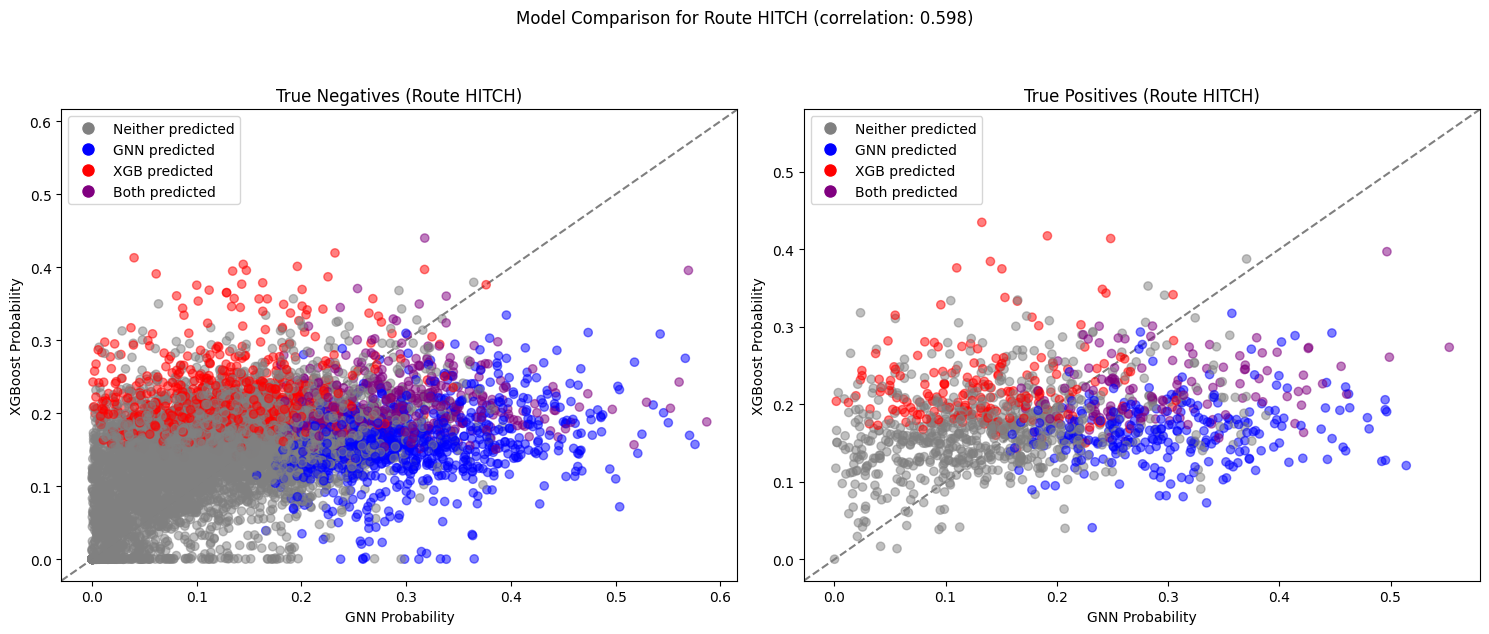


Statistics for Route HITCH:
Number of true positives: 1319
Number of true negatives: 8703
Overall correlation: 0.598

True Positive Predictions:
Both models correct: 126
Only GNN correct: 261
Only XGB correct: 200
Neither correct: 732

True Negative Predictions:
Both predicted incorrectly: 402
Only GNN predicted incorrectly: 942
Only XGB predicted incorrectly: 892
Neither predicted incorrectly: 6467


In [37]:
i = 6  # Route index to analyze
create_corr_plot(i, all_gnn_preds, all_xgb_preds, all_true_labels, route_names)

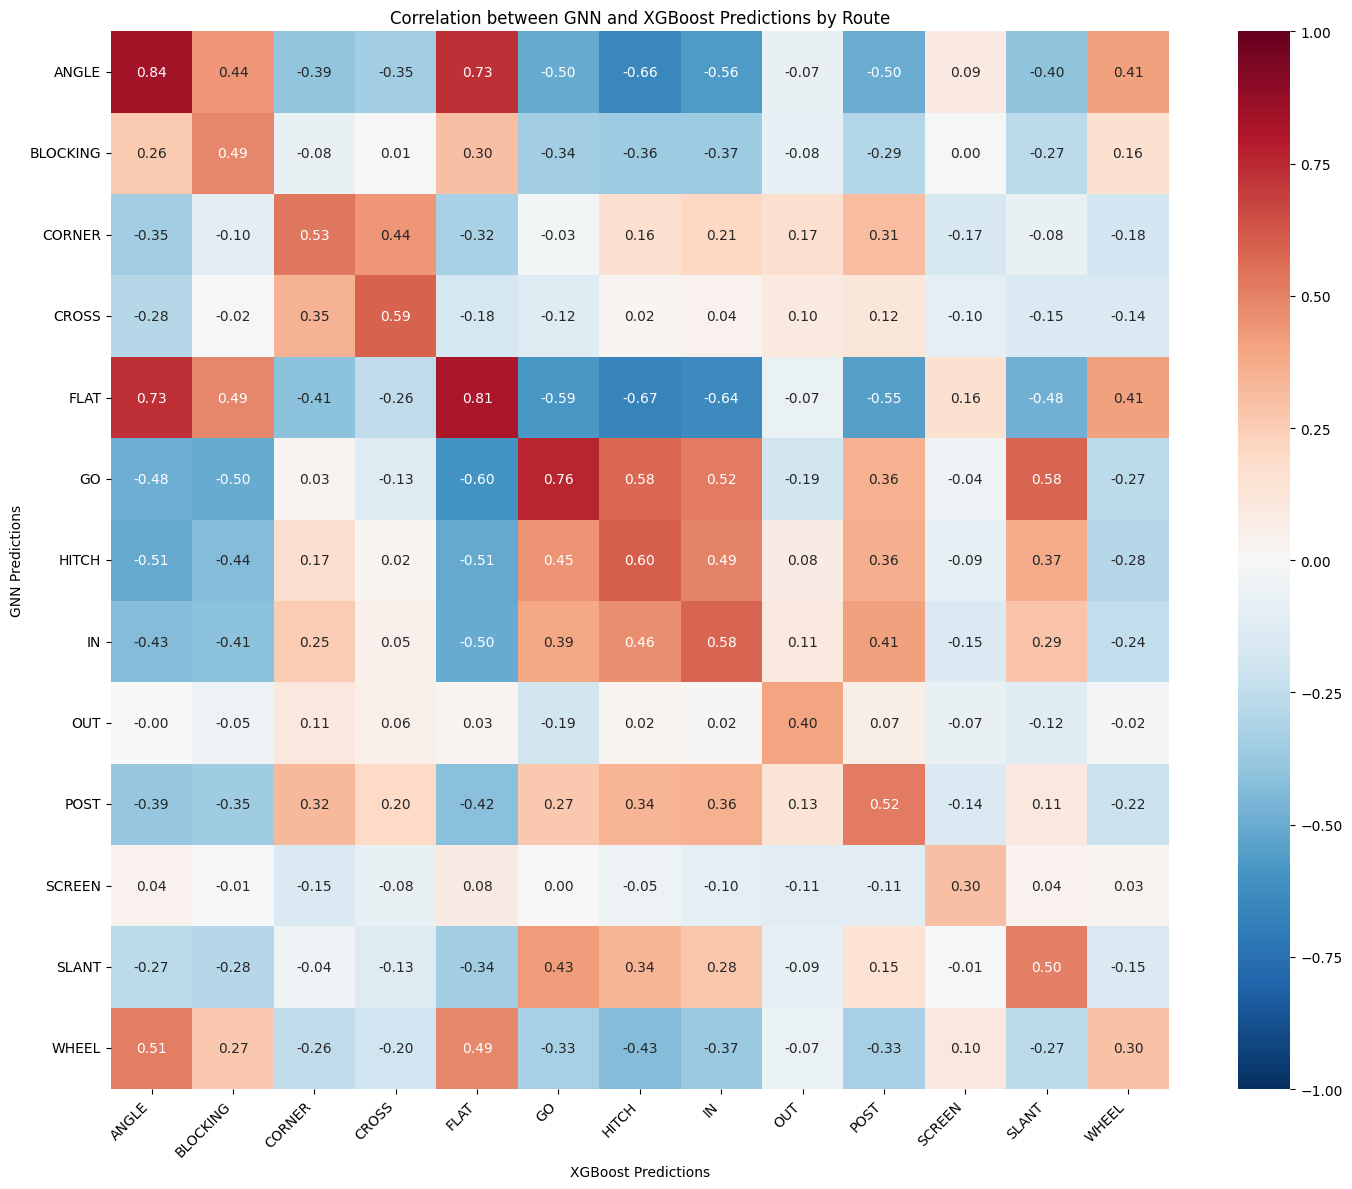


Summary Statistics:
Average correlation: 0.006
Median correlation: -0.015
Max correlation: 0.839
Min correlation: -0.666

Correlations for same route predictions:
ANGLE: 0.839
BLOCKING: 0.491
CORNER: 0.532
CROSS: 0.593
FLAT: 0.815
GO: 0.759
HITCH: 0.598
IN: 0.579
OUT: 0.403
POST: 0.518
SCREEN: 0.301
SLANT: 0.503
WHEEL: 0.296


In [38]:
feature_encoders = encoders

# Convert route indices to names
route_names = feature_encoders['routeRan'].inverse_transform(range(all_gnn_preds.shape[1]))

# Calculate correlations between GNN and XGB predictions for each route
n_classes = all_gnn_preds.shape[1]
correlation_matrix = np.zeros((n_classes, n_classes))

for i in range(n_classes):
    for j in range(n_classes):
        correlation_matrix[i, j] = pearsonr(all_gnn_preds[:, i], all_xgb_preds[:, j])[0]

# Create heatmap
plt.figure(figsize=(15, 12))
sns.heatmap(
    correlation_matrix,
    xticklabels=route_names,
    yticklabels=route_names,
    cmap='RdBu_r',  # Red-Blue diverging colormap
    vmin=-1,
    vmax=1,
    center=0,
    annot=True,  # Show correlation values
    fmt='.2f',   # Format correlation values to 2 decimal places
    square=True  # Make cells square
)

plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.xlabel('XGBoost Predictions')
plt.ylabel('GNN Predictions')
plt.title('Correlation between GNN and XGBoost Predictions by Route')

# Adjust layout to prevent label cutoff
plt.tight_layout()
plt.show()

# Print some summary statistics
print("\nSummary Statistics:")
print(f"Average correlation: {np.mean(correlation_matrix):.3f}")
print(f"Median correlation: {np.median(correlation_matrix):.3f}")
print(f"Max correlation: {np.max(correlation_matrix):.3f}")
print(f"Min correlation: {np.min(correlation_matrix):.3f}")

# Print diagonal correlations (same route predictions)
print("\nCorrelations for same route predictions:")
for i, route in enumerate(route_names):
    print(f"{route}: {correlation_matrix[i, i]:.3f}")

In [39]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pandas as pd

def plot_as_misclassifications(y_true, y_pred, feature_encoders, figsize=(15, 12)):
    """
    Create a visualization of AS route misclassifications.
    
    Parameters:
    -----------
    y_true : array-like
        True labels (encoded)
    y_pred : array-like
        Predicted labels (encoded)
    feature_encoders : dict
        Dictionary containing the label encoders, with 'routeRan' key
    figsize : tuple
        Figure size in inches (width, height)
    """
    # Get route names from encoder
    route_names = unique_routes
    
    # Convert one-hot y_true to class indices
    y_true_indices = np.argmax(y_true, axis=1)
    
    # Convert probability predictions to class indices
    y_pred_indices = np.argmax(y_pred, axis=1)
    
    # Now calculate confusion matrix
    conf_matrix = confusion_matrix(y_true_indices, y_pred_indices)
    
    # Create a mask to hide diagonal elements (correct classifications)
    mask = np.eye(len(route_names), dtype=bool)
    
    # Create figure and axis
    plt.figure(figsize=figsize)
    
    # Create heatmap with masked diagonal
    sns.heatmap(
        conf_matrix,
        mask=mask,
        xticklabels=route_names,
        yticklabels=route_names,
        cmap='YlOrRd',  # Yellow-Orange-Red colormap for misclassifications
        annot=True,     # Show values
        fmt='d',        # Format as integers
        square=True,    # Make cells square
        cbar_kws={'label': 'Number of Misclassifications'}
    )
    
    # Adjust labels
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.xlabel('Predicted AS Route')
    plt.ylabel('True AS Route')
    plt.title('AS Route Misclassification Patterns\n(Diagonal/Correct Classifications Hidden)')
    
    # Adjust layout to prevent label cutoff
    plt.tight_layout()
    
    # Print top misclassifications
    print("\nTop 10 Most Common Misclassifications:")
    misclass_data = []
    for i in range(len(route_names)):
        for j in range(len(route_names)):
            if i != j:  # Exclude diagonal
                misclass_data.append({
                    'True AS': route_names[i],
                    'Predicted AS': route_names[j],
                    'Count': conf_matrix[i, j]
                })
    
    # Convert to DataFrame and sort
    misclass_df = pd.DataFrame(misclass_data)
    misclass_df = misclass_df.sort_values('Count', ascending=False)
    
    print(misclass_df.head(10).to_string(index=False))
    
    # Calculate and print overall statistics
    total_samples = conf_matrix.sum()
    correct_predictions = conf_matrix.diagonal().sum()
    misclassifications = total_samples - correct_predictions
    
    print(f"\nOverall Statistics:")
    print(f"Total Samples: {total_samples}")
    print(f"Correct Predictions: {correct_predictions}")
    print(f"Total Misclassifications: {misclassifications}")
    print(f"Overall Accuracy: {correct_predictions/total_samples:.2%}")
    
    return plt.gcf()

# Example usage:
# plot_as_misclassifications(y_true, y_pred, feature_encoders)

## Ensemble

In [40]:
# train_weeks = list(range(7, 8))
# val_weeks = list(range(8,9))
# test_weeks = list(range(9,10))
train_weeks = list(range(7,8))
val_weeks = list(range(8,9))
test_weeks = list(range(9,10))

In [41]:
encoders['routeRan'].inverse_transform([3])[0]

'CROSS'

In [42]:
from dataclasses import dataclass
import torch
import torch.nn as nn
import numpy as np
import xgboost as xgb
from typing import Dict, Optional, Union, Literal
from sklearn.metrics import log_loss, accuracy_score

@dataclass
class EnsembleConfig:
    meta_type: Literal['nn', 'gbm'] = 'nn'
    # NN params
    lr: float = 1e-3
    batch_size: int = 32
    epochs: int = 10
    patience: int = 5
    # GBM params
    gbm_params: Dict = None
    scheduler_type = 'cosine'
    gamma = 0.7
    min_lr = .00001
    
    
    def __post_init__(self):
        if self.meta_type == 'gbm' and not self.gbm_params:
            self.gbm_params = {
                'objective': 'multi:softprob',
                'learning_rate': 0.1,
                'max_depth': 4,
                'n_estimators': 100,
                'early_stopping_rounds': 10
            }

class MetaLearner(nn.Module):
    def __init__(self, num_classes: int, meta_type: str, gbm_params: Dict = None):
        super().__init__()
        self.meta_type = meta_type
        if meta_type == 'nn':
            self.model = nn.Sequential(
                nn.Linear(2 * num_classes, 64),
                nn.GELU(),
                nn.Dropout(0.1),
                nn.Linear(64, 64),
                nn.GELU(),
                nn.Dropout(0.1),
                nn.Linear(64, 64),
                nn.Linear(64, num_classes)
            )
        else:
            self.model = xgb.XGBClassifier(num_class=num_classes, **gbm_params)
    
    def forward(self, x: Union[torch.Tensor, np.ndarray]) -> Union[torch.Tensor, np.ndarray]:
        if self.meta_type == 'nn':
            return torch.softmax(self.model(x), dim=-1)
        return self.model.predict_proba(x)

class RouteEnsemble(nn.Module):
    def __init__(
        self, 
        xgb_model, 
        gnn_model, 
        config: EnsembleConfig,
        num_classes: int,
        feature_encoders,
        device: str = 'cuda',
        scaler=None
    ):
        super().__init__()
        self.xgb_model = xgb_model
        self.gnn_model = gnn_model
        self.config = config
        self.device = device
        self.feature_encoders = feature_encoders
        self.scaler = scaler
        self.meta_learner = MetaLearner(
            num_classes=num_classes,
            meta_type=config.meta_type,
            gbm_params=config.gbm_params
        ).to(device)
        
        if config.meta_type == 'nn':
            self.optimizer = torch.optim.AdamW(
                self.meta_learner.parameters(),
                lr=config.lr
            )
            self.criterion = nn.CrossEntropyLoss()
            # Initialize scheduler based on type
            if config.scheduler_type == 'cosine':
                self.scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
                    self.optimizer,
                    T_max=config.epochs,
                    eta_min=config.min_lr
                )
            else:  # 'step'
                self.scheduler = torch.optim.lr_scheduler.StepLR(
                    self.optimizer,
                    step_size=config.step_size,
                    gamma=config.gamma
                )

    def forward(self, batch) -> Dict[str, torch.Tensor]:
        """Forward pass compatible with evaluation function"""
        # Get base model predictions
        xgb_probs, gnn_probs, _ = self._get_single_batch_base_predictions(batch, self.current_plays_df)
        
        # Combine predictions using meta-learner
        if self.config.meta_type == 'nn':
            x = torch.cat([xgb_probs, gnn_probs], dim=1)
            combined_logits = self.meta_learner.model(x)  # Get logits before softmax
            return {"route_predictions": combined_logits, "gnn": torch.FloatTensor(gnn_probs), "xgb": torch.FloatTensor(xgb_probs)}
        else:
            x = np.concatenate([xgb_probs, gnn_probs], axis=1)
            combined_probs = self.meta_learner.model.predict_proba(x)
            # Convert to logits for compatibility
            combined_logits = torch.FloatTensor(np.log(combined_probs + 1e-10)).to(self.device)
            return {"route_predictions": combined_probs, "gnn": torch.FloatTensor(gnn_probs), "xgb": torch.FloatTensor(xgb_probs)}

    def _get_single_batch_base_predictions(self, batch, plays_df) -> tuple:
        """Get predictions from base models"""
        all_xgb, all_gnn, all_labels = [], [], []
        
        # Get corresponding plays for XGBoost
        ids = list(zip(batch.game_id.cpu().tolist(), batch.play_id.cpu().tolist()))
        batch_df = filter_by_game_play_ids(plays_df, ids)
        
        # GNN predictions
        gnn_batch = batch.to(self.device)
        gnn_out = self.gnn_model(gnn_batch)["route_predictions"]
        gnn_probs = torch.softmax(gnn_out, dim=-1).detach().cpu().numpy()
        
        # XGB predictions
        X, y, _, _2 = prepare_route_prediction_data(batch_df, training=False, feature_encoders=self.feature_encoders, scaler=self.scaler)
        self.X_prepared = X
        xgb_probs = self.xgb_model.predict_proba(X)

        return xgb_probs, gnn_probs, y
    
    def _get_base_predictions(self, loader, plays_df) -> tuple:
        """Get predictions from base models"""
        all_xgb, all_gnn, all_labels = [], [], []
        
        for batch in loader:
            xgb_probs, gnn_probs, y = self._get_single_batch_base_predictions(batch, plays_df)
            all_xgb.append(xgb_probs)
            all_gnn.append(gnn_probs)
            all_labels.append(y)
        
        xgb_preds = np.concatenate(all_xgb)
        gnn_preds = np.concatenate(all_gnn)
        labels = np.concatenate(all_labels)
        
        if self.config.meta_type == 'nn':
            xgb_preds = torch.FloatTensor(xgb_preds).to(self.device)
            gnn_preds = torch.FloatTensor(gnn_preds).to(self.device)
            labels = torch.LongTensor(labels).to(self.device)
            
        return xgb_preds, gnn_preds, labels
    
    def _train_nn_epoch(self, xgb_preds, gnn_preds, labels):
        indices = torch.randperm(len(labels))
        losses = []
        
        for i in range(0, len(labels), self.config.batch_size):
            idx = indices[i:i + self.config.batch_size]
            x = torch.cat([xgb_preds[idx], gnn_preds[idx]], dim=1)
            
            self.optimizer.zero_grad()
            out = self.meta_learner(x)
            loss = self.criterion(out, labels[idx])
            loss.backward()
            self.optimizer.step()
            losses.append(loss.item())
            
        return np.mean(losses)
    
    def _evaluate(self, xgb_preds, gnn_preds, labels):
        if self.config.meta_type == 'nn':
            self.meta_learner.eval()
            with torch.no_grad():
                x = torch.cat([xgb_preds, gnn_preds], dim=1)
                out = self.meta_learner(x)
                loss = self.criterion(out, labels).item()
                preds = out.argmax(dim=1).cpu()
                acc = accuracy_score(labels.cpu(), preds)
        else:
            x = np.concatenate([xgb_preds, gnn_preds], axis=1)
            out = self.meta_learner.model.predict_proba(x)
            loss = log_loss(labels, out)
            acc = accuracy_score(labels, out.argmax(axis=1))
            
        return {'loss': loss, 'accuracy': acc}
    
    def train_ensemble(self, train_loader, train_df, val_loader=None, val_df=None):
        """Train the ensemble"""
        print("Caching base model predictions...")
        train_preds = self._get_base_predictions(train_loader, train_df)
        val_preds = None if val_loader is None else self._get_base_predictions(val_loader, val_df)
        
        print(f"Training {self.config.meta_type.upper()} meta-learner...")
        best_val_loss = float('inf')
        patience_counter = 0
        
        if self.config.meta_type == 'nn':
            for epoch in range(self.config.epochs):
                self.meta_learner.train()
                train_loss = self._train_nn_epoch(*train_preds)
                
                metrics = {'train_loss': train_loss}
                if val_preds:
                    val_metrics = self._evaluate(*val_preds)
                    metrics.update({f'val_{k}': v for k, v in val_metrics.items()})
                    
                    if val_metrics['loss'] < best_val_loss:
                        best_val_loss = val_metrics['loss']
                        patience_counter = 0
                        self.save_checkpoint('best_ensemble_model.pt')
                    else:
                        patience_counter += 1
                        
                    if patience_counter >= self.config.patience:
                        print("Early stopping triggered")
                        break
                
                print(f"Epoch {epoch+1}/{self.config.epochs} -", 
                      " - ".join(f"{k}: {v:.4f}" for k, v in metrics.items()))
        else:
            X_train = np.concatenate([train_preds[0], train_preds[1]], axis=1)
            eval_set = None
            if val_preds:
                X_val = np.concatenate([val_preds[0], val_preds[1]], axis=1)
                eval_set = [(X_train, train_preds[2]), (X_val, val_preds[2])]
            
            self.meta_learner.model.fit(
                X_train, train_preds[2],
                eval_set=eval_set,
                verbose=True,
            )
            # Step 5: Generate predictions and metrics
            self.test_preds = self.meta_learner.model.predict(X_val)
            self.test_true = val_preds[2]
            self.test_pred_a = self.meta_learner.model.predict_proba(X_val)
            self.train_preds = self.meta_learner.model.predict(X_train)
            self.train_pred_a = self.meta_learner.model.predict_proba(X_train)
            self.train_true = train_preds[2]
            
    def predict(self, loader, plays_df):
        """Generate ensemble predictions"""
        xgb_preds, gnn_preds, labels = self._get_base_predictions(loader, plays_df)
        
        if self.config.meta_type == 'nn':
            self.meta_learner.eval()
            with torch.no_grad():
                x = torch.cat([xgb_preds, gnn_preds], dim=1)
                ensemble_preds = self.meta_learner(x).cpu().numpy()
        else:
            x = np.concatenate([xgb_preds, gnn_preds], axis=1)
            ensemble_preds = self.meta_learner.model.predict_proba(x)
        
        return {
            'ensemble_preds': ensemble_preds,
            'xgb_preds': xgb_preds.cpu().numpy() if torch.is_tensor(xgb_preds) else xgb_preds,
            'gnn_preds': gnn_preds.cpu().numpy() if torch.is_tensor(gnn_preds) else gnn_preds,
            'labels': labels.cpu().numpy() if torch.is_tensor(labels) else labels
        }

    def set_plays_df(self, df):
        """Set the current plays DataFrame for forward pass"""
        self.current_plays_df = df
    
    def save_checkpoint(self, path: str):
        if self.config.meta_type == 'nn':
            torch.save({
                'model_state': self.meta_learner.state_dict(),
                'optimizer_state': self.optimizer.state_dict(),
                'config': self.config
            }, path)
        else:
            self.meta_learner.model.save_model(path)
    
    def load_checkpoint(self, path: str):
        if self.config.meta_type == 'nn':
            checkpoint = torch.load(path)
            self.meta_learner.load_state_dict(checkpoint['model_state'])
            self.optimizer.load_state_dict(checkpoint['optimizer_state'])
        else:
            self.meta_learner.model.load_model(path)

# Example usage:
"""
config = EnsembleConfig(
    meta_type='nn',  # or 'gbm'
    lr=1e-3,
    epochs=10,
    patience=5
)

ensemble = RouteEnsemble(
    xgb_model=xgb_model,
    gnn_model=gnn_model,
    config=config,
    num_classes=5
)

# Train
ensemble.train(
    train_loader=train_loader,
    train_df=train_df,
    val_loader=val_loader,
    val_df=val_df
)

# Predict
results = ensemble.predict(test_loader, test_df)
"""

"\nconfig = EnsembleConfig(\n    meta_type='nn',  # or 'gbm'\n    lr=1e-3,\n    epochs=10,\n    patience=5\n)\n\nensemble = RouteEnsemble(\n    xgb_model=xgb_model,\n    gnn_model=gnn_model,\n    config=config,\n    num_classes=5\n)\n\n# Train\nensemble.train(\n    train_loader=train_loader,\n    train_df=train_df,\n    val_loader=val_loader,\n    val_df=val_df\n)\n\n# Predict\nresults = ensemble.predict(test_loader, test_df)\n"

## Evaluation

In [43]:
train_loader, val_loader, test_loader, indices, week_ranges = create_week_stratified_split(
        dataset, 
        train_weeks=train_weeks,
        val_weeks=val_weeks,
        test_weeks=test_weeks,
        batch_size=128, 
        random_seed=42,
        preserve_time_order=False,
        val_random=False  # Whether to randomly sample validation set from train period
)

Train set size: 990
Validation set size: 1047
Test set size: 913
Train weeks: [7]
Validation weeks: [8]
Test weeks: [9]


In [44]:
from nfl_data_bowl.ensemble_trainer import RouteEnsemble, MetaLearner, EnsembleConfig

In [45]:
feature_encoders

{'possessionTeam': LabelEncoder(),
 'defensiveTeam': LabelEncoder(),
 'yardlineSide': LabelEncoder(),
 'offenseFormation': LabelEncoder(),
 'receiverAlignment': LabelEncoder(),
 'down': LabelEncoder(),
 'position': LabelEncoder(),
 'quarter': LabelEncoder(),
 'routeRan': LabelEncoder(),
 'scaler': StandardScaler()}

In [46]:
import torch
import numpy as np
from scipy.stats import entropy
from sklearn.metrics import classification_report
import pandas as pd
import torch
import numpy as np
from scipy.stats import ks_2samp
import matplotlib.pyplot as plt
from collections import defaultdict
from IPython.display import display, HTML
from typing import Tuple, Optional

def evaluate_ensemble(
    ensemble: RouteEnsemble,
    dataloader: DataLoader,
    plays_df: pd.DataFrame,
    dataset=None,
    device: str = 'cuda'
) -> Tuple[Dict, Tuple[np.ndarray, np.ndarray, np.ndarray]]:
    """
    Evaluates the ensemble model with enhanced metrics
    
    Parameters:
    - ensemble: RouteEnsemble model
    - dataloader: PyTorch DataLoader for evaluation
    - plays_df: DataFrame containing play data for XGBoost
    - device: Device to run evaluation on
    
    Returns:
    - metrics: Dictionary containing various evaluation metrics
    - (y_test, y_pred, y_pred_proba): Raw predictions and true labels
    """
    ensemble.gnn_model.eval()
    all_predictions = []
    all_probabilities = []
    all_targets = []
    prev = 0
    
    with torch.no_grad():
        for batch in tqdm.tqdm(dataloader, desc="Evaluating"):
            # Get time stats if available
            if hasattr(batch, 'time'):
                batch_time = batch.time.float().mean().item()
                batch_min = batch.time.float().min().item()
                batch_max = batch.time.float().max().item()
                print(
                    f"Batch average time diff from prev: {batch_time - prev:.3f}, "
                    f"batch min: {batch_min}, batch max: {batch_max}"
                )
                prev = batch_time
            
            # Get game/play IDs for this batch
            id_pairs = list(zip(
                batch.game_id.cpu().tolist(),
                batch.play_id.cpu().tolist()
            ))
            batch_df = filter_by_game_play_ids(plays_df, id_pairs)
            
            # Get ensemble predictions
            pred = ensemble(batch)['route_predictions']
            
            # Get targets for eligible receivers
            targets = batch.route_targets[batch.eligible_mask]
            
            # Store predictions and targets
            all_predictions.append(np.argmax(pred, axis=1))
            all_probabilities.append(pred)
            all_targets.append(targets.cpu().numpy())
    
    # Concatenate all batches
    y_pred = np.concatenate(all_predictions)
    y_pred_proba = np.concatenate(all_probabilities)
    y_test = np.concatenate(all_targets)
    
    # Calculate basic metrics
    metrics = classification_report(y_test, y_pred, output_dict=True)
    
    # Calculate actual vs predicted counts
    actuals_predictions = pd.DataFrame({
        'Actual': y_test,
        'Predicted': y_pred
    })

    for class_label in np.unique(y_test):
        actual_count = len(actuals_predictions[actuals_predictions['Actual'] == class_label])
        predicted_count = len(actuals_predictions[actuals_predictions['Predicted'] == class_label])
        metrics[str(class_label)]['actual_count'] = actual_count
        metrics[str(class_label)]['predicted_count'] = predicted_count
    
    # Calculate uncertainty metrics
    def calculate_uncertainty_metrics(probabilities, y_true):
        prediction_entropies = np.apply_along_axis(entropy, 1, probabilities)
        true_label_probs = np.array([prob[true] for prob, true in zip(probabilities, y_true)])
        log_likelihood = np.log(true_label_probs + 1e-10)
        max_entropy = np.log2(probabilities.shape[1])
        normalized_entropies = prediction_entropies / max_entropy
        sorted_probs = np.sort(probabilities, axis=1)
        entropy_margin = sorted_probs[:, -1] - sorted_probs[:, -2]
        
        return {
            'mean_entropy': np.mean(prediction_entropies),
            'median_entropy': np.median(prediction_entropies),
            'mean_normalized_entropy': np.mean(normalized_entropies),
            'mean_entropy_margin': np.mean(entropy_margin),
            'mean_log_likelihood': np.mean(log_likelihood),
            'median_log_likelihood': np.median(log_likelihood)
        }
    
    metrics['uncertainty_metrics'] = calculate_uncertainty_metrics(y_pred_proba, y_test)

    # Calculate Top-K accuracy
    def top_k_accuracy(y_true, y_pred_proba, k):
        top_k_predictions = np.argsort(y_pred_proba, axis=1)[:, -k:]
        correct = 0
        for i, true_label in enumerate(y_true):
            if true_label in top_k_predictions[i]:
                correct += 1
        return correct / len(y_true)
    
    metrics['top_2_accuracy'] = top_k_accuracy(y_test, y_pred_proba, 2)
    metrics['top_3_accuracy'] = top_k_accuracy(y_test, y_pred_proba, 3)
    
   # New formatted output function using pandas DataFrames
    def display_formatted_metrics(metrics_dict, dataset_):
        # Per-class metrics table
        class_metrics = []
        for class_label in sorted([k for k in metrics_dict.keys() 
                                 if k.isdigit()]):
            try:
                class_metrics.append({
                    'Route': dataset.idx_to_route[int(class_label)],
                    'Actual Count': metrics_dict[class_label]['actual_count'],
                    'Predicted Count': metrics_dict[class_label]['predicted_count'],
                    'Precision': f"{metrics_dict[class_label]['precision']:.3f}",
                    'Recall': f"{metrics_dict[class_label]['recall']:.3f}",
                    'F1-score': f"{metrics_dict[class_label]['f1-score']:.3f}",
                    'Support': metrics_dict[class_label]['support']
                })
            except Exception as e:
                print(e)
                print(f"Could not get metrics for {class_label}")
                
        class_df = pd.DataFrame(class_metrics)
        
        # Top-K accuracy table
        topk_metrics = pd.DataFrame([{
            'Metric': 'Accuracy Type',
            'Top-1 (standard)': f"{metrics_dict['accuracy']:.3f}",
            'Top-2': f"{metrics_dict['top_2_accuracy']:.3f}",
            'Top-3': f"{metrics_dict['top_3_accuracy']:.3f}"
        }])
        
        # Uncertainty metrics table
        uncertainty_df = pd.DataFrame([{
            'Mean Entropy': f"{metrics_dict['uncertainty_metrics']['mean_entropy']:.3f}",
            'Median Entropy': f"{metrics_dict['uncertainty_metrics']['median_entropy']:.3f}",
            'Mean Normalized Entropy': f"{metrics_dict['uncertainty_metrics']['mean_normalized_entropy']:.3f}",
            'Mean Entropy Margin': f"{metrics_dict['uncertainty_metrics']['mean_entropy_margin']:.3f}",
            'Mean Log Likelihood': f"{metrics_dict['uncertainty_metrics']['mean_log_likelihood']:.3f}",
            'Median Log Likelihood': f"{metrics_dict['uncertainty_metrics']['median_log_likelihood']:.3f}"
        }])
        
        # Overall metrics table
        overall_metrics = []
        for avg_type in ['macro avg', 'weighted avg']:
            metrics_row = {'Average Type': avg_type}
            metrics_row.update({k: f"{v:.3f}" for k, v in metrics_dict[avg_type].items()})
            overall_metrics.append(metrics_row)
        overall_df = pd.DataFrame(overall_metrics)
        
        # Display tables with styling
        print("\n=== Per-Class Performance ===")
        display(HTML(class_df.style.set_properties(**{
            'text-align': 'center',
            'padding': '8px'
        }).to_html()))
        
        print("\n=== Top-K Accuracy ===")
        display(HTML(topk_metrics.style.set_properties(**{
            'text-align': 'center',
            'padding': '8px'
        }).to_html()))
        
        print("\n=== Uncertainty Metrics ===")
        display(HTML(uncertainty_df.style.set_properties(**{
            'text-align': 'center',
            'padding': '8px'
        }).to_html()))
        
        print("\n=== Overall Metrics ===")
        display(HTML(overall_df.style.set_properties(**{
            'text-align': 'center',
            'padding': '8px'
        }).to_html()))

    metrics["display_tables"] = lambda: display_formatted_metrics(metrics, ensemble)

    print('done')
    
    return metrics, (y_test, y_pred, y_pred_proba)

In [47]:
config = EnsembleConfig(
    meta_type='nn',  # or 'gbm'
    lr=0.75 * 1e-3,
    epochs=125,
    patience=15,
    gbm_params={"max_depth": 4, "n_estimators": 30}
)

ensemble = RouteEnsemble(
    xgb_model=xgb_model,
    gnn_model=model,
    config=config,
    num_classes=13,
    device='cpu',
    feature_encoders=encoders,
    scaler=feature_encoders['scaler'],
    debug=True
)

# Train
ensemble.train_ensemble(
    train_loader=train_loader,
    train_df=enriched_df,
    val_loader=val_loader,
    val_df=enriched_df,
)

Caching base model predictions...
Training NN meta-learner...
Epoch 1/125 - train_loss: 2.4062 - val_loss: 2.1298 - val_accuracy: 0.2493
Epoch 2/125 - train_loss: 2.1005 - val_loss: 2.0819 - val_accuracy: 0.2545
Epoch 3/125 - train_loss: 2.0755 - val_loss: 2.0709 - val_accuracy: 0.2580
Epoch 4/125 - train_loss: 2.0545 - val_loss: 2.0549 - val_accuracy: 0.2648
Epoch 5/125 - train_loss: 2.0486 - val_loss: 2.0470 - val_accuracy: 0.2650
Epoch 6/125 - train_loss: 2.0361 - val_loss: 2.0355 - val_accuracy: 0.2700
Epoch 7/125 - train_loss: 2.0335 - val_loss: 2.0298 - val_accuracy: 0.2694
Epoch 8/125 - train_loss: 2.0212 - val_loss: 2.0260 - val_accuracy: 0.2739
Epoch 9/125 - train_loss: 2.0293 - val_loss: 2.0170 - val_accuracy: 0.2780
Epoch 10/125 - train_loss: 2.0140 - val_loss: 2.0129 - val_accuracy: 0.2770
Epoch 11/125 - train_loss: 2.0089 - val_loss: 2.0121 - val_accuracy: 0.2821
Epoch 12/125 - train_loss: 2.0064 - val_loss: 2.0134 - val_accuracy: 0.2821
Epoch 13/125 - train_loss: 1.9996 -

In [48]:
ensemble.set_plays_df(enriched_df)  # This is crucial - don't forget this step!

# 4. Run the evaluation
metrics_xgb_ensemble, (y_test, y_pred, y_pred_proba, predictions_df) = evaluate_route_predictions_table(
    model=ensemble,
    dataloader_=val_loader,
    device='cpu',
    dataset_=dataset,
    key="xgb"
)
# 5. Display the results
metrics_xgb_ensemble["display_tables"]()


=== Per-Class Performance ===


,Route,Actual Count,Predicted Count,Precision,Recall,F1-score,Support
0,ANGLE,189,17,0.176,0.016,0.029,189.000000
1,BLOCKING,663,527,0.328,0.261,0.291,663.000000
2,SCREEN,224,44,0.409,0.080,0.134,224.000000
3,SLANT,214,29,0.172,0.023,0.041,214.000000
4,WHEEL,24,3,0.000,0.000,0.000,24.000000
5,CORNER,181,49,0.102,0.028,0.043,181.000000
6,CROSS,439,530,0.272,0.328,0.297,439.000000
7,FLAT,664,1179,0.387,0.687,0.495,664.000000
8,GO,819,1707,0.318,0.662,0.429,819.000000
9,HITCH,665,772,0.192,0.223,0.206,665.000000



=== Top-K Accuracy ===


,Metric,Top-1 (standard),Top-2,Top-3
0,Accuracy Type,0.304,0.497,0.642



=== Uncertainty Metrics ===


,Mean Entropy,Median Entropy,Mean Normalized Entropy,Mean Entropy Margin,Mean Log Likelihood,Median Log Likelihood
0,1.895,2.030,0.512,0.118,-1.915,-1.837



=== Overall Metrics ===


,Average Type,precision,recall,f1-score,support
0,macro avg,0.244,0.191,0.172,5155.000
1,weighted avg,0.283,0.304,0.252,5155.000


In [49]:
metrics_gnn_ensemble, (y_test, y_pred, y_pred_proba, predictions_df) = evaluate_route_predictions_table(
    model=ensemble,
    dataloader_=val_loader,
    device='cpu',
    dataset_=dataset,
    key="gnn"
)
# 5. Display the results
metrics_gnn_ensemble["display_tables"]()


=== Per-Class Performance ===


,Route,Actual Count,Predicted Count,Precision,Recall,F1-score,Support
0,ANGLE,189,127,0.244,0.164,0.196,189.000000
1,BLOCKING,663,548,0.265,0.219,0.239,663.000000
2,SCREEN,224,189,0.148,0.125,0.136,224.000000
3,SLANT,214,197,0.127,0.117,0.122,214.000000
4,WHEEL,24,0,0.000,0.000,0.000,24.000000
5,CORNER,181,65,0.185,0.066,0.098,181.000000
6,CROSS,439,563,0.233,0.298,0.261,439.000000
7,FLAT,664,869,0.375,0.491,0.425,664.000000
8,GO,819,1007,0.298,0.366,0.329,819.000000
9,HITCH,665,848,0.206,0.263,0.231,665.000000



=== Top-K Accuracy ===


,Metric,Top-1 (standard),Top-2,Top-3
0,Accuracy Type,0.249,0.427,0.577



=== Uncertainty Metrics ===


,Mean Entropy,Median Entropy,Mean Normalized Entropy,Mean Entropy Margin,Mean Log Likelihood,Median Log Likelihood
0,1.739,1.819,0.470,0.165,-2.214,-1.955



=== Overall Metrics ===


,Average Type,precision,recall,f1-score,support
0,macro avg,0.193,0.185,0.184,5155.000
1,weighted avg,0.234,0.249,0.237,5155.000


In [50]:
metrics_ensemble, (y_test, y_pred, y_pred_proba, predictions_df) = evaluate_route_predictions_table(
    model=ensemble,
    dataloader_=val_loader,
    device='cpu',
    dataset_=dataset,
    softmax=True
)
# 5. Display the results
metrics_ensemble["display_tables"]()


=== Per-Class Performance ===


,Route,Actual Count,Predicted Count,Precision,Recall,F1-score,Support
0,ANGLE,189,2,0.000,0.000,0.000,189.000000
1,BLOCKING,663,858,0.314,0.406,0.354,663.000000
2,SCREEN,224,55,0.327,0.080,0.129,224.000000
3,SLANT,214,10,0.100,0.005,0.009,214.000000
4,WHEEL,24,0,0.000,0.000,0.000,24.000000
5,CORNER,181,0,0.000,0.000,0.000,181.000000
6,CROSS,439,486,0.265,0.294,0.279,439.000000
7,FLAT,664,915,0.390,0.538,0.452,664.000000
8,GO,819,1699,0.301,0.624,0.406,819.000000
9,HITCH,665,1086,0.186,0.304,0.231,665.000000



=== Top-K Accuracy ===


,Metric,Top-1 (standard),Top-2,Top-3
0,Accuracy Type,0.289,0.478,0.621



=== Uncertainty Metrics ===


,Mean Entropy,Median Entropy,Mean Normalized Entropy,Mean Entropy Margin,Mean Log Likelihood,Median Log Likelihood
0,1.935,2.042,0.523,0.111,-1.963,-1.910



=== Overall Metrics ===


,Average Type,precision,recall,f1-score,support
0,macro avg,0.156,0.175,0.146,5155.000
1,weighted avg,0.211,0.289,0.229,5155.000


## Test Results

In [53]:
ensemble.set_plays_df(enriched_df)  # This is crucial - don't forget this step!

# 4. Run the evaluation
metrics, (y_test, y_pred, y_pred_proba, preds_df) = evaluate_route_predictions_table(
    model=ensemble,
    dataloader_=test_loader,
    device='cpu',
    dataset_=dataset,
    softmax=True
)

# 5. Display the results
metrics["display_tables"]()


=== Per-Class Performance ===


,Route,Actual Count,Predicted Count,Precision,Recall,F1-score,Support
0,ANGLE,160,2,1.000,0.013,0.025,160.000000
1,BLOCKING,551,755,0.330,0.452,0.381,551.000000
2,SCREEN,168,33,0.424,0.083,0.139,168.000000
3,SLANT,212,19,0.158,0.014,0.026,212.000000
4,WHEEL,20,0,0.000,0.000,0.000,20.000000
5,CORNER,180,0,0.000,0.000,0.000,180.000000
6,CROSS,396,406,0.264,0.270,0.267,396.000000
7,FLAT,590,765,0.412,0.534,0.465,590.000000
8,GO,700,1490,0.272,0.579,0.370,700.000000
9,HITCH,560,975,0.184,0.320,0.233,560.000000



=== Top-K Accuracy ===


,Metric,Top-1 (standard),Top-2,Top-3
0,Accuracy Type,0.284,0.480,0.620



=== Uncertainty Metrics ===


,Mean Entropy,Median Entropy,Mean Normalized Entropy,Mean Entropy Margin,Mean Log Likelihood,Median Log Likelihood
0,1.937,2.043,0.524,0.110,-1.950,-1.901



=== Overall Metrics ===


,Average Type,precision,recall,f1-score,support
0,macro avg,0.249,0.175,0.148,4491.000
1,weighted avg,0.256,0.284,0.227,4491.000


# Visuals

In [ ]:
import ipywidgets as widgets
from IPython.display import display, HTML
import torch
import pandas as pd
import numpy as np
from torch_geometric.data import Data

class RoutePredictor(widgets.VBox):
    def __init__(self):
        # Create route definitions
        self.route_definitions = {
            'Slant': {
                'path': lambda x, y: f'M {x} {y} l 40 -40',  # Diagonal up
                'color': '#ffeb3b'
            },
            'Go Route': {
                'path': lambda x, y: f'M {x} {y} l 0 -80',  # Straight up
                'color': '#ffeb3b'
            },
            'Out Route': {
                'path': lambda x, y: (
                    # If x position is in left half of field, route goes left
                    f'M {x} {y} l 0 -40 l -60 0' if x < 300 else
                    # If x position is in right half of field, route goes right
                    f'M {x} {y} l 0 -40 l 60 0'
                ),
                'color': '#ffeb3b'
            },
            'In Route': {
                'path': lambda x, y: (
                    # If x position is in left half of field, route goes right
                    f'M {x} {y} l 0 -40 l 60 0' if x < 300 else
                    # If x position is in right half of field, route goes left
                    f'M {x} {y} l 0 -40 l -60 0'
                ),
                'color': '#ffeb3b'
            }
        }

        # Create player controls dictionary with default positions
        self.players = {
            # Offensive players - positioned at bottom
            'WR1': {'color': 'blue', 'active': True, 'player_id': 1001, 'type': 'offense', 
                   'default_x': 15, 'default_y': 70},  # Far left WR
            'WR2': {'color': 'blue', 'active': False, 'player_id': 1002, 'type': 'offense',
                   'default_x': 30, 'default_y': 70},  # Inside left WR
            'WR3': {'color': 'blue', 'active': False, 'player_id': 1003, 'type': 'offense',
                   'default_x': 70, 'default_y': 70},  # Inside right WR
            'WR4': {'color': 'blue', 'active': False, 'player_id': 1004, 'type': 'offense',
                   'default_x': 85, 'default_y': 70},  # Far right WR
            'TE': {'color': 'purple', 'active': False, 'player_id': 1005, 'type': 'offense',
                  'default_x': 40, 'default_y': 70},   # Tight end position
            
            # Defensive players - positioned at top
            'CB1': {'color': 'red', 'active': True, 'player_id': 2001, 'type': 'defense',
                   'default_x': 15, 'default_y': 50},  # Matching WR1
            'CB2': {'color': 'red', 'active': False, 'player_id': 2002, 'type': 'defense',
                   'default_x': 30, 'default_y': 50},  # Matching WR2
            'SS': {'color': 'orange', 'active': False, 'player_id': 2003, 'type': 'defense',
                  'default_x': 45, 'default_y': 30},   # Strong safety deeper
            'FS': {'color': 'orange', 'active': False, 'player_id': 2004, 'type': 'defense',
                  'default_x': 55, 'default_y': 30}    # Free safety deeper
        }
        
        # Initialize controls for each player
        for player_id in self.players:
            self.players[player_id].update({
                'active_checkbox': widgets.Checkbox(
                    value=self.players[player_id]['active'],
                    description=f'Show {player_id}',
                    style={'description_width': 'initial'}
                ),
                'x_slider': widgets.FloatSlider(
                    value=self.players[player_id]['default_x'],
                    min=0,
                    max=100,
                    step=1,
                    description=f'{player_id} X:',
                    style={'description_width': 'initial'},
                    disabled=not self.players[player_id]['active']
                ),
                'y_slider': widgets.FloatSlider(
                    value=self.players[player_id]['default_y'],
                    min=0,
                    max=100,
                    step=1,
                    description=f'{player_id} Y:',
                    style={'description_width': 'initial'},
                    disabled=not self.players[player_id]['active']
                )
            })
            
            # Bind checkbox event to enable/disable sliders
            self.players[player_id]['active_checkbox'].observe(
                lambda change, pid=player_id: self.toggle_player(change, pid), 
                names='value'
            )

        # RB control
        self.rb_checkbox = widgets.Checkbox(
            value=False,
            description='Show RB',
            style={'description_width': 'initial'}
        )
        
        self.calculate_button = widgets.Button(
            description='Calculate Routes',
            button_style='success'
        )
        
        # Create output area for predictions
        self.output = widgets.Output()
        
        # Create the field visualization
        self.field = widgets.HTML()
        
        # Update the field initially
        self.update_field()
        
        # Bind control events
        for player in self.players.values():
            player['x_slider'].observe(lambda _: self.update_field(), names='value')
            player['y_slider'].observe(lambda _: self.update_field(), names='value')
        self.rb_checkbox.observe(lambda _: self.update_field(), names='value')
        self.calculate_button.on_click(self.on_calculate)
        
        # Create controls layout with player groups
        controls = [widgets.HTML('<h3>Player Controls</h3>')]
        
        # Group players by type (offense/defense)
        offense_controls = [widgets.HTML('<h4>Offense</h4>')]
        defense_controls = [widgets.HTML('<h4>Defense</h4>')]
        
        for player_id, player in self.players.items():
            player_group = widgets.VBox([
                player['active_checkbox'],
                player['x_slider'],
                player['y_slider'],
                widgets.HTML('<hr>')  # Divider between players
            ])
            if player['type'] == 'offense':
                offense_controls.append(player_group)
            else:
                defense_controls.append(player_group)
        
        controls.extend([
            widgets.VBox(offense_controls),
            widgets.VBox(defense_controls),
            self.rb_checkbox,
            self.calculate_button
        ])
        
        controls_box = widgets.VBox(controls)
        
        # Initialize the parent widget
        super().__init__([
            self.field,
            controls_box,
            self.output
        ])
    
    def toggle_player(self, change, player_id):
        self.players[player_id]['active'] = change['new']
        self.players[player_id]['x_slider'].disabled = not change['new']
        self.players[player_id]['y_slider'].disabled = not change['new']
        self.update_field()
    
    def update_field(self):
        # Create field HTML with yard lines and SVG overlay for routes
        yard_lines = ''
        for i in range(10):
            yard_lines += f'''
                <div style="position: absolute; 
                           left: {i * 10}%; 
                           height: 100%; 
                           width: 1px; 
                           background-color: white; 
                           opacity: 0.3;">
                </div>
            '''
        
        # Create player dots and routes
        player_dots = ''
        routes_svg = ''
        
        # Calculate the SVG viewport dimensions based on the field size
        field_width = 600
        field_height = 300
        
        for player_id, player in self.players.items():
            if player['active_checkbox'].value:
                # Calculate actual pixel coordinates
                x_pixels = (player['x_slider'].value / 100) * field_width
                y_pixels = (player['y_slider'].value / 100) * field_height
                
                # Add player dot
                player_dots += f'''
                    <div style="position: absolute; 
                               left: {player['x_slider'].value}%; 
                               top: {player['y_slider'].value}%; 
                               width: 20px; 
                               height: 20px; 
                               background-color: {player['color']}; 
                               border-radius: 50%; 
                               transform: translate(-50%, -50%);">
                        <div style="position: absolute; 
                                  top: -20px; 
                                  left: 50%; 
                                  transform: translateX(-50%); 
                                  color: white; 
                                  font-size: 12px; 
                                  text-shadow: 1px 1px 1px black;">
                            {player_id}
                        </div>
                    </div>
                '''
                
                # Add route if it's an offensive player
                if player['type'] == 'offense':
                    routes_svg += f'''
                        <path d="{self.route_definitions['Slant']['path'](x_pixels, y_pixels)}"
                              stroke="{self.route_definitions['Slant']['color']}"
                              stroke-width="2"
                              fill="none"
                              opacity="0.6"/>
                    '''
        
        # Add RB if enabled
        rb_dot = '''
            <div style="position: absolute; 
                       left: 45%; 
                       top: 70%; 
                       width: 20px; 
                       height: 20px; 
                       background-color: red; 
                       border-radius: 50%; 
                       transform: translate(-50%, -50%);">
                <div style="position: absolute; 
                           top: -20px; 
                           left: 50%; 
                           transform: translateX(-50%); 
                           color: white; 
                           font-size: 12px; 
                           text-shadow: 1px 1px 1px black;">
                    RB
                </div>
            </div>
        ''' if self.rb_checkbox.value else ''
        
        # Create SVG overlay for routes
        svg_overlay = f'''
            <svg style="position: absolute; 
                       top: 0; 
                       left: 0; 
                       width: 100%; 
                       height: 100%; 
                       pointer-events: none;">
                {routes_svg}
            </svg>
        '''
        
        self.field.value = f'''
            <div style="width: 600px; 
                       height: 300px; 
                       background-color: #4CAF50; 
                       margin: 10px; 
                       border: 2px solid black;
                       position: relative;
                       overflow: hidden;">
                {yard_lines}
                {player_dots}
                {rb_dot}
                {svg_overlay}
            </div>
        '''
    
    def create_batch_data(self):
        """Creates a batch of data for route prediction based on current player positions"""
        active_players = [pid for pid, p in self.players.items() if p['active_checkbox'].value]
        num_players = len(active_players)
        
        # Create a DataFrame with player positions and attributes
        player_data = []
        for player_id, player in self.players.items():
            if player['active_checkbox'].value:
                player_data.append({
                    'nflId': player['player_id'],
                    'position': player_id[:2],  # Get position type (WR, TE, CB, SS, FS)
                    'x': player['x_slider'].value,
                    'y': player['y_slider'].value,
                    'weight': 200,  # Mock values
                    'height_inches': 72,
                    's': 0,  # Speed set to 0 for static position
                    'is_offense': 1 if player['type'] == 'offense' else 0,
                    'route_encoded': None
                })
        
        frame_data = pd.DataFrame(player_data)
        
        # Create node features
        node_features = []
        player_ids = []
        eligible_mask = []
        
        for _, player in frame_data.iterrows():
            # Create position encoding
            position_tensor = torch.tensor([1 if player['position'] == 'WR' else 2])
            weight_tensor = torch.tensor([player['weight']])
            height_tensor = torch.tensor([player['height_inches']])
            is_offense_tensor = torch.tensor([player['is_offense']])
            motion_tensor = torch.tensor([np.abs(player['s'])])
            x_pos = torch.tensor([player['x'] / 100.0])  # Normalize to [0,1]
            y_pos = torch.tensor([player['y'] / 100.0])  # Normalize to [0,1]
            
            features = torch.cat([
                position_tensor, weight_tensor, height_tensor, 
                is_offense_tensor, motion_tensor, x_pos, y_pos
            ])
            
            node_features.append(features)
            player_ids.append(player['nflId'])
            eligible_mask.append(1 if player['is_offense'] == 1 else 0)  # Only offensive players eligible

        # Create edge connections with distance and angle calculations
        edge_index = []
        edge_attr = []
        frame_idx = 0  # Single frame

        for i in range(len(frame_data)):
            for j in range(i + 1, len(frame_data)):
                node1 = frame_data.iloc[i]
                node2 = frame_data.iloc[j]

                # Calculate Euclidean distance
                dist = np.sqrt(
                    (node1['x'] - node2['x'])**2 + 
                    (node1['y'] - node2['y'])**2
                )

                if dist <= 100:  # Distance threshold
                    edge_index.extend([[i, j]])
                    edge_attr.extend([[dist, frame_idx, 1, 0]])  # Added 0 for potential additional feature

        # Convert everything to tensors with the correct shapes
        node_features = torch.stack(node_features)
        player_ids = torch.tensor(player_ids, dtype=torch.long)
        eligible_mask = torch.tensor(eligible_mask, dtype=torch.bool)
        edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
        edge_attr = torch.tensor(edge_attr, dtype=torch.float)

        # Create time tensor (single value repeated for each node)
        time = torch.full((1,), 1800.0)  # 30 minutes in seconds
        
        # Create the Data object with the specified structure
        data = Data(
            x=node_features,
            edge_index=edge_index,
            edge_attr=edge_attr,
            time=time,
            play_id=torch.full_like(player_ids, 1),
            game_id=torch.full_like(player_ids, 1),
            batch=torch.zeros_like(player_ids, dtype=torch.long),
            eligible_mask=eligible_mask,
            route_targets=torch.zeros_like(player_ids, dtype=torch.long),
            down=torch.tensor([1]),
            distance=torch.tensor([10.0]),
            quarter=torch.tensor([1]),
            game_clock=torch.tensor([[1800.0]]),
            offense_team=torch.tensor([0]),
            offense_score=torch.tensor([0.0]),
            defense_score=torch.tensor([0.0]),
            week=torch.tensor([1]),
            yards_to_go=torch.tensor([10.0]),
            player_ids=player_ids,
            plays_elapsed=torch.zeros_like(player_ids, dtype=torch.long)
        )

        return data
    
    def predict_routes(self, data):
        """
        Mock route prediction based on player positions
        Returns probabilities for each route type
        """
        predictions = {}
        for i, player_id in enumerate(data.player_ids):
            if data.eligible_mask[i]:
                x_pos = data.x[i, -2].item() * 100  # Convert back to 0-100 scale
                y_pos = data.x[i, -1].item() * 100
                
                # Base probabilities
                slant_prob = 40
                go_route_prob = 30
                out_route_prob = 30
                
                # Adjust based on x position
                if x_pos > 70:
                    go_route_prob += 10
                    slant_prob -= 5
                    out_route_prob -= 5
                elif x_pos < 30:
                    out_route_prob += 10
                    slant_prob += 5
                    go_route_prob -= 15
                
                # Adjust based on y position
                if y_pos > 70:
                    out_route_prob += 15
                    slant_prob -= 10
                    go_route_prob -= 5
                
                # Find player ID in our players dict
                player_name = next(name for name, p in self.players.items() 
                                 if p['player_id'] == player_id.item())
                
                predictions[player_name] = {
                    'slant': max(0, min(100, slant_prob)),
                    'go_route': max(0, min(100, go_route_prob)),
                    'out_route': max(0, min(100, out_route_prob))
                }
        
        return predictions
    
    def on_calculate(self, b):
        with self.output:
            self.output.clear_output()
            
            # Create batch data from current positions
            batch_data = self.create_batch_data()
            
            # Get predictions
            predictions = self.predict_routes(batch_data)
            
            print("Predicted Routes:")
            for player_id, routes in predictions.items():
                print(f"\n{player_id}:")
                print(f"Slant: {routes['slant']}%")
                print(f"Go Route: {routes['go_route']}%")
                print(f"Out Route: {routes['out_route']}%")

In [ ]:
from IPython.display import display
import torch
from torch_geometric.data import Data

# First create and display the predictor
predictor = RoutePredictor()
display(predictor)